# Reading Cloud-Optimized GeoTIFFs the Hard Way

In this notebook we will explore how one can read Cloud-Optimized GeoTIFFs (COGs) the hard way, i.e., by requesting and parsing byte ranges by hand. We'll query the Earth Search STAC catalog to find an image in COG format, parse the embedded metadata and file structure out of the file, then use that information to read the bytes of an image tile from the file and process them into a usable numpy array. We'll then visualize that array in a slippy map to verify what we did got us the expected result.

Before we get into it, we have to get some initial stuff out of the way, like imports and some other defs we'll need for later.

In [1]:
from __future__ import annotations

import dataclasses
import enum
import itertools
import json
import math
import struct
import urllib.request

from glob import glob
from pathlib import Path
from pprint import pprint
from typing import Any, Iterator, Literal, Self

import folium
import numpy as np
import pyproj
import shapely

from pystac_client import Client

In [2]:
# This is a mapping of the TIFF data types to the struct package's format charaters
# see https://docs.python.org/3/library/struct.html#format-characters

DATA_TYPES = {
    1: '1B',  # BYTE (uint8)
    2: '1s',  # ASCII (char[1])
    3: '1H',  # SHORT (uint16)
    4: '1I',  # LONG (uint32)
    5: '2I',  # RATIONAL (uint32[2])
    6: '1b',  # SBYTE (int8)
    7: '1B',  # UNDEFINED (uint8)
    8: '1h',  # SSHORT (int16)
    9: '1i',  # SLONG (int32)
    10: '2i',  # SRATIONAL (int32[2])
    11: '1f',  # FLOAT (float32)
    12: '1d',  # DOUBLE (float64)
    13: '1I',  # SUBIFD (uint32)
    # 14: '',
    # 15: '',
    16: '1Q',  # ? (uint64)
    17: '1q',  # ? (int64)
    18: '1Q',  # ? (uint64)
}

In [3]:
ENDIANNESS = {
    b'MM': '>',  # big endian
    b'II': '<',  # little endian
}

In [4]:
def url_read_bytes(url: str, start: int, end: int) -> bytes:
    request = urllib.request.Request(
        url,
        headers={'Range': f'bytes={start}-{end-1}'},
    )
    with urllib.request.urlopen(request) as response:
        return response.read()

## Point of Interest (POI)

To give us something to use for our query, let's define a point of interest.

In [5]:
# Point of Interest
POI = shapely.Point(-121.695833, 45.373611)

It would be good if we know where this point is, don't you think? We'll use the Folium library to create a leaflet map with our point on it.

In [6]:
location = (POI.coords[0][1], POI.coords[0][0])

point_map = folium.Map(
    location=location,
    tiles='CartoDB positron',
)

folium.CircleMarker(
    location=location,
    fill=True,
    fill_opacity=0.6,
).add_to(point_map)

point_map

## Querying Earth Search

We'll use pystac-client to search the Earth Search Sentinel 2 L2A collection for a scene intersecting our POI. We'll aim for something with low cloud cover, in the year 2023, and we'll pick the most recent scene that matches these parameters.

**WARNING**: You _can_ change this to fetch scenes from a different collection, STAC API, or not use STAC and just put in an href directly to a COG of your choosing. Doing so is STRONGLY discouraged while in the workshop, as differences in the way the file was created might be impossible to overcome within the time limits of this workshop. Consider leaving this as-is to start, and at a later date, when you have more familiarity parsing TIFFs, you can try a different source.

In [7]:
client = Client.open("https://earth-search.aws.element84.com/v1")

search = client.search(
    max_items=1,
    collections=['sentinel-2-c1-l2a'],
    intersects=POI,
    datetime='2023/2023',
    query=['eo:cloud_cover<10'],
    sortby=[{"direction": "desc", "field": "properties.datetime"}],
)
item = next(search.items())
pprint(item.to_dict())

{'assets': {'aot': {'file:checksum': '1220acf5f2c6389f16bdd5ccc980ece525d8bf58a7bc4cc94cd94db2208b5b064e07',
                    'file:size': 2163428,
                    'gsd': 20,
                    'href': 'https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/10/T/FR/2023/12/S2B_T10TFR_20231223T190950_L2A/AOT.tif',
                    'proj:shape': [5490, 5490],
                    'proj:transform': [20, 0, 600000, 0, -20, 5100000],
                    'raster:bands': [{'data_type': 'uint16',
                                      'nodata': 0,
                                      'offset': 0,
                                      'scale': 0.001,
                                      'spatial_resolution': 20}],
                    'roles': ['data'],
                    'title': 'Aerosol optical thickness (AOT)',
                    'type': 'image/tiff; application=geotiff; '
                            'profile=cloud-optimized'},
            'blue': {'

We can throw that item onto our map to see its footprint relative to our POI.

In [8]:
folium.GeoJson(item).add_to(point_map)
point_map

Notably, the item we retrieved has many different bands, all of them COGs. We only need one for this exercise, so we'll grab the red band's href because that should be a good looking band visually.

In [9]:
href = item.assets['red'].href
print(href)

https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/10/T/FR/2023/12/S2B_T10TFR_20231223T190950_L2A/B04.tif


## The TIFF file header

The first few bytes of a TIFF file tell us a couple important things we'll need to process the rest of the file. First is the endianness of the file, second is that the file is really a TIFF file.

Note that not all files called `.tif` are a standard TIFF. Most notably, a standard TIFF file uses 32-bit integer offsets within the file to index particular bytes within the file (such as the offset to the first byte in an image tile, for example). Due to the maximum value of such an integer, standard TIFF files have a maximum file size of 4GB (or 2GB for certain implementations that mistakenly use _signed_ integers for offsets). To get around this limitation, the BigTIFF format was developed using 64-bit integer offsets--but this is not a standard TIFF! It is close, but different enough we're not going to worry about supporting it for our little TIFF "library" that we're going to build.

Actually, we're not going to support a lot of things. This implementation is going to be very specific to what we need for the specific Earth Search COG we selected. That's okay: sometimes a purpose-built implementation is more performant because it doesn't have to handle all the weird edge cases. Or at least that's what we can tell ourselves as we go along and notice that we're not handling some condition we know is specific to our image in a more general way. :)

### So what's in the header already?

Enough jibber-jabber, let's read out the header. It's the first 4 bytes of a standard TIFF.

In [10]:
header = url_read_bytes(href, 0, 4)
print(header)
print(header.hex())

b'II*\x00'
49492a00


### Endianness

TIFF uses the first two bytes of the file to encode the endianness of the file. This presumably enables writers to use the most efficient endianess for their host system, if needed. Readers must support reading big or little endian files, where writers can pick one endianness.

Big endian is encoded as `MM` (from Motorola processors), and little endian is encoded as `II` (from Intel processors).

The doubled letter is used to ensure that the characters are read the same no matter the endianness. This is because the endianness just affects the order of the bytes in the two-byte words, not the order of the bits within the bytes.

In [11]:
# big endian signature, unpack big endian
print(bin(struct.unpack('>H', b'MM')[0]))
# big endian signature, unpack little endian
print(bin(struct.unpack('<H', b'MM')[0]))

# little endian signature, unpack big endian
print(bin(struct.unpack('>H', b'II')[0]))
# little endian signature, unpack little endian
print(bin(struct.unpack('<H', b'II')[0]))

0b100110101001101
0b100110101001101
0b100100101001001
0b100100101001001


Note the use of the `struct` module above. This is a module from the Python stdlib that is super handy when working with binary data, as it is able to pack (Python type to binary representation) and unpack (binary representation to Python type) data values given a specific format. In the above examples, `>` and '<` designate big and little endianness, respectively. The `H` indicates that the data type is `uint16`. See the `DATA_TYPES` dict defined near the beginning of this notebook, or review [the struct docs](https://docs.python.org/3/library/struct.html) for more about its operation and the format codes available.

In [12]:
# our image signature
print(header[0:2])
endianness = ENDIANNESS[header[0:2]]  # We'll need this later, so let's save it into a var now

b'II'


Note that we can check the endianness of our system rather easily:

In [13]:
import sys
sys.byteorder

'little'

But note that the endianness of our system really doesn't have any bearing on how we process the data in a TIFF file. We care about endianness so we can ensure we can interpret the bytes in each word in the file in the appropriate order. Beyond that we shouldn't have to worry about endianness. Endianness is not as hard or consequential as some might have you believe (because some people have an incorrect mental model that makes handling endianness more complicated than it really is).

### Magic number

Many files encode a special number in their first few bytes, which can be used to distingush the files is of a given format. Wikipedia has [a big long list of these "magic numbers"](https://en.wikipedia.org/wiki/List_of_file_signatures) for anyone that is curious. TIFF uses the value `42` for it's magic number (and BigTIFF 43).

In [14]:
magic_number = struct.unpack(f'{endianness}H', header[2:4])[0]
magic_number

42

## First IFD offset: the next four bytes

Immediately following the TIFF header is the offset to the first image file directory (IFD) in the file. In a standard TIFF this offset is a 32-bit unsigned integer, as was previously alluded. We can read in and view those bytes:

In [15]:
ifd_offset_bytes = url_read_bytes(href, 4, 8)
print(ifd_offset_bytes)

b'\xc0\x00\x00\x00'


Though that's not super useful until we unpack those bytes into in integer (here using `I` because the offset is a `uint32` value):

In [16]:
ifd_offset = struct.unpack(f'{endianness}I', ifd_offset_bytes)[0]
print(ifd_offset)

192


## Parsing the Image File Directory

The Image File Directory (IFD) is a data structure composed of entries called tags (hence the name "Tag Image File Format"). The IFD doesn't start with the first tag entry, however. It begins with a 2-byte `unit16` value indicating the number of tags within the IFD. This value enables us, along with the IFD offset within the file, to read the entire sequence of tag bytes via `file_bytes[ifd_offset + 2:ifd_offset + (tags_count * tag_size)]`.

### Tag structure

In a standard TIFF, tags are a 12-byte sequence (so `tag_size` above is 12 bytes) of the following structure:

| Tag Bytes | Tag field name  | Field data type |
| --------- | --------------- | --------------- |
| 0 - 1     | `code`          | `uint16`        |
| 2 - 3     | `data_type`     | `uint16`        |
| 4 - 7     | `count`         | `uint32`        |
| 8 - 11    | `value`         | `char[4]`       |

In the case of BigTIFF files, each tag is a 20-byte sequence where the `count` and `value` are of type `uint64`.

The tag `code` field gives us a way to find the meaning of the tag `value`, as the `code` is an integer that maps to the tag name. The Library of Congress has [a handy table](https://www.loc.gov/preservation/digital/formats/content/tiff_tags.shtml) we can use to look up the tags by their codes.

#### Tag data types

The tag `data_type` is also an integer value, in this case mapping to the data type we can use to interpret `value` per the following table:

| `data_type` | Type Name | Data type   |
| ----------- | --------- | ----------- |
| 1           | BYTE      | `uint8`     |
| 2           | ASCII     | `char[1]`   |
| 3           | SHORT     | `uint16`    |
| 4           | LONG      | `uint32`    |
| 5           | RATIONAL  | `uint32[2]` |
| 6           | SBYTE     | `int8`      |
| 7           | UNDEFINED | `uint8`     |
| 8           | SSHORT    | `int16`     |
| 9           | SLONG     | `int32`     |
| 10          | SRATIONAL | `int32[2]`  |
| 11          | FLOAT     | `float32`   |
| 12          | DOUBLE    | `float64`   |
| 13          | SUBIFD    | `uint32`    |
| 14          | n/a       | n/a         |
| 15          | n/a       | n/a         |
| 16          | ?         | `uint64`    |
| 17          | ?         | `int64`     |
| 18          | ?         | `uint64`    |

(I believe data types 16, 17, and 18 are specifc to BigTIFF, but I have so far been unable to find confirmation either way.)

The `count` field tells us how many of the listed `data_type` make up the `value` of the tag. Note that even a `count` of just one for a `data_type` of, say 5, or two `uint32`s would not fit in a `value` in a standard TIFF file as `value` itself is only four bytes long. Similarly, a `count` greater than 4 with a `data_type` of 1 (`uint8`) would also be larger than can fit in `value`.

In such cases where `count * len_in_bytes(data_type) > 4`, `value` itself is not actually the tag value but an offset to the actual value within the file. The length of that value is given by the previous expression `count * len_in_bytes(data_type)`. Thus, to get the actual value we can read `file_bytes[value:value + (count * len_in_bytes(data_type))]`.

The IFD doesn't end with the last tag either. Each IFD contains a 4-byte (`uint32`) offset to the next IFD in the file (or 8-byte `uint64` in the case of BigTIFF). In the event an IFD is the last one in the file it will have a value of 0 for its next IFD offset. As a result, it should be possible to build a map of the complete contents of a TIFF by iterating through its IFDs and parsing their tags into some appropriate hierarchical data structure (TIFF --< IFDs --< Image segments) .

### Finding the tag count and reading the tag bytes

As mentioned, an IFD starts with a 2-byte `uint16` value indicating its number of tags. If we have an IFD's offset (`ifd_offset`) within the file--which for the first IFD we know is given to us as the first bytes in the file immediately following the TIFF header--then we also know that IFS's tag offset (`tags_start`) is given by `ifd_offset + 2`.

Parsing the tag count (`tags_count`) should simply be a matter of using `struct.unpack` to unpack the two tag count bytes into an integer (struct format char `H` for `uint16`). We need to make sure we use the endianness indicicated in the file header. `<` is little endian in `struct.unpack`, where `>` is big endian. Looking back, the proper endian character should have been saved into the `endianness` var for us back when we were inspecting the header bytes.

In [17]:
tags_start = ifd_offset + 2
tags_count = struct.unpack(f'{endianness}H', url_read_bytes(href, ifd_offset, tags_start))[0]
tags_count

19

If we know the tag count and the tag size (12 bytes for TIFF, 20 for BigTIFF), then we can find the total number of bytes in the IFD's tags by `tag_count * tag_size`. From this we should be able to find the last byte of the tags with `tags_end = tags_start + (tag_count * tag_size)`, allowing us to read the tag bytes (`tags_bytes`) from the file.

In [18]:
tag_size = 12  # because we only support standard TIFF
tags_end = tags_start + (tags_count * tag_size)
tags_bytes = url_read_bytes(href, tags_start, tags_end)
tags_bytes

b'\x00\x01\x03\x00\x01\x00\x00\x00\xe4*\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\xe4*\x00\x00\x02\x01\x03\x00\x01\x00\x00\x00\x10\x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x08\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1c\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00=\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00B\x01\x03\x00\x01\x00\x00\x00\x00\x04\x00\x00C\x01\x03\x00\x01\x00\x00\x00\x00\x04\x00\x00D\x01\x04\x00y\x00\x00\x00X\x07\x00\x00E\x01\x04\x00y\x00\x00\x00<\t\x00\x00S\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x0e\x83\x0c\x00\x03\x00\x00\x00\xca\x03\x00\x00\x82\x84\x0c\x00\x06\x00\x00\x00\xe2\x03\x00\x00\xaf\x87\x03\x00 \x00\x00\x00\x12\x04\x00\x00\xb1\x87\x02\x00\x1e\x00\x00\x00R\x04\x00\x00\x80\xa4\x02\x00 \x02\x00\x00\xaa\x01\x00\x00\x81\xa4\x02\x00\x02\x00\x00\x000\x00\x00\x00'

In [19]:
next_ifd_offset = struct.unpack(f'{endianness}I', url_read_bytes(href, tags_end, tags_end + 4))[0]
next_ifd_offset

1136

It's also important to note that we can use the `tags_end` to know the offset of the next IFD offset, which a 4-byte value we can unpack into a `uint32` (for a standard TIFF).

### Parsing each tag

To parse each tag we need to find a way to split each tag's bytes out of the of the larger bytes string. Python gives us many valid ways of doing this. Let's start by using a list comprehension to split the tags bytes into a list of byte strings for each tag an see what those look like.

In [20]:
tag_bytes_list = [tags_bytes[i*tag_size:(i*tag_size)+tag_size] for i in range(len(tags_bytes)//tag_size)]
for tag_bytes in tag_bytes_list:
    print(tag_bytes)

b'\x00\x01\x03\x00\x01\x00\x00\x00\xe4*\x00\x00'
b'\x01\x01\x03\x00\x01\x00\x00\x00\xe4*\x00\x00'
b'\x02\x01\x03\x00\x01\x00\x00\x00\x10\x00\x00\x00'
b'\x03\x01\x03\x00\x01\x00\x00\x00\x08\x00\x00\x00'
b'\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00'
b'\x15\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00'
b'\x1c\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00'
b'=\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00'
b'B\x01\x03\x00\x01\x00\x00\x00\x00\x04\x00\x00'
b'C\x01\x03\x00\x01\x00\x00\x00\x00\x04\x00\x00'
b'D\x01\x04\x00y\x00\x00\x00X\x07\x00\x00'
b'E\x01\x04\x00y\x00\x00\x00<\t\x00\x00'
b'S\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00'
b'\x0e\x83\x0c\x00\x03\x00\x00\x00\xca\x03\x00\x00'
b'\x82\x84\x0c\x00\x06\x00\x00\x00\xe2\x03\x00\x00'
b'\xaf\x87\x03\x00 \x00\x00\x00\x12\x04\x00\x00'
b'\xb1\x87\x02\x00\x1e\x00\x00\x00R\x04\x00\x00'
b'\x80\xa4\x02\x00 \x02\x00\x00\xaa\x01\x00\x00'
b'\x81\xa4\x02\x00\x02\x00\x00\x000\x00\x00\x00'


#### Unpacking the tag values

With a way to extract each tag's bytes, we next need to use `struct.unpack` to extract the byte values into some we can use in python for the tag's `code`, `data_type`, `count`, and `value`. Remember that `code` and `data_type` are `uint16` values, which map to the struct `H` format. Look up the proper struct format values for `count` and `value` knowing what you know about the data types of those tag fields and verify if the format passed into `struct.unpack` in the example here is correct (feel free to consult the `DATA_TYPES` dict above or the struct docs directly).

For variety, this example implementation uses a `while` loop to extract the tag bytes. Each tag's fields are added into a dictionary indexed by the tag `code` to facilitate easy access in later code.

In [21]:
tags = {}
tag_index = 0

while tag_index < tags_count:
    try:
        tag_bytes = tags_bytes[tag_size * tag_index:(tag_size * (tag_index + 1))]
        tag_index += 1
    except IndexError:
        break

    code, data_type, count, value = struct.unpack(f'{endianness}HHI4s', tag_bytes)
    tags[code] = {
        'data_type': data_type,
        'count': count,
        'value': value,
    }

tags

{256: {'data_type': 3, 'count': 1, 'value': b'\xe4*\x00\x00'},
 257: {'data_type': 3, 'count': 1, 'value': b'\xe4*\x00\x00'},
 258: {'data_type': 3, 'count': 1, 'value': b'\x10\x00\x00\x00'},
 259: {'data_type': 3, 'count': 1, 'value': b'\x08\x00\x00\x00'},
 262: {'data_type': 3, 'count': 1, 'value': b'\x01\x00\x00\x00'},
 277: {'data_type': 3, 'count': 1, 'value': b'\x01\x00\x00\x00'},
 284: {'data_type': 3, 'count': 1, 'value': b'\x01\x00\x00\x00'},
 317: {'data_type': 3, 'count': 1, 'value': b'\x02\x00\x00\x00'},
 322: {'data_type': 3, 'count': 1, 'value': b'\x00\x04\x00\x00'},
 323: {'data_type': 3, 'count': 1, 'value': b'\x00\x04\x00\x00'},
 324: {'data_type': 4, 'count': 121, 'value': b'X\x07\x00\x00'},
 325: {'data_type': 4, 'count': 121, 'value': b'<\t\x00\x00'},
 339: {'data_type': 3, 'count': 1, 'value': b'\x01\x00\x00\x00'},
 33550: {'data_type': 12, 'count': 3, 'value': b'\xca\x03\x00\x00'},
 33922: {'data_type': 12, 'count': 6, 'value': b'\xe2\x03\x00\x00'},
 34735: {'data

#### Understanding tag codes

Now that we have TIFF tag values to look at, it would be good to mention the [Libray of Congress' guide to TIFF Tags](https://www.loc.gov/preservation/digital/formats/content/tiff_tags.shtml) again. We can use that lookup table to interpret each of the integer codes in a meaningful way. Note that some codes we will see in every file, while others may be specific to the way a file was encoded or the type of data it contains. Further, a number of the tags are specific to the GeoTIFF format and are required for such files, while some are used for metadata by GDAL and can generally be expected in a GeoTIFF (though not always of course).

For example, we should always expect to see 256, 257, 258, and 259 (and others, these are just good examples):

| Code | Tag Name      | Tag Description              |
| ---- | ------------- | ---------------------------- |
| 256  | ImageWidth    | Number of image columns      |
| 257  | ImageLength   | Number of image rows         |
| 258  | BitsPerSample | Number of bits in each pixel |
| 259  | Compression   | Integer mapping to compression algorithm used for each image segment |

#### Unpacking the tag values

Recalling the earlier explanation about tag data types, counts, and values, we know that unpacking the tag values will not be the same for each tag given the differences in those three aforementioned tag fields across each of our different tags. For some tags that have a single count of a shorter data type we can unpack the tag `value` directly. But for longer values we'll have to use the tag `value` as an offset into the file to read the actual bytes to unpack.

We'll start with one of these easier examples and unpack the image size tags 256 and 257. Check the data types for these tags. What are the struct format chars for each? Will we need to unpack all four bytes of the `value` for either of these tags?

In [22]:
# image column count (width)
cols = struct.unpack(endianness + 'H', tags[256]['value'][0:struct.calcsize('H')])[0]

# image row count (height)
# we can also resolve the struct char in a more automated fashion
tag = tags[257]
struct_dtype = DATA_TYPES[tag['data_type']]
rows = struct.unpack(endianness + struct_dtype, tags[257]['value'][0:struct.calcsize(struct_dtype)])[0]

print(f'Image size is {cols} x {rows}')

Image size is 10980 x 10980


In the cases where the tag `value`'s four bytes are not sufficient to contain the whole tag value, parsing is a bit more complex. We not only need to find the struct format character (`struct_dtype`) and size for the tag's data type, but then we need to:

* use the data type size and the tag `count` to calculate how many bytes we need to read (`size`)
* unpack the `value` to get the actual value's byte offset in the file (`offset`)
* combine `size` and `offset` to get the byte range and read that out fo the file (giving us `values`)
* build the struct format string (`endianness + (struct_dtype * count)`) then unpack `values`

We'll preview this here with an example unpacking the tile offsets tag (324). The values we get out of this (`tile_offsets`) are the byte offsets for each image segment (tile) in the image represented by this IFD. We will be able to use these offsets in the next section to read the specific tile containing our POI (though we'll have unpack the rest of our tags and do a bit of math to figure out which one and what to do with the bytes).

In [23]:
tag = tags[324]
struct_dtype = DATA_TYPES[tag['data_type']]
size = tag['count'] * struct.calcsize(struct_dtype)
offset = struct.unpack(f'{endianness}I', tag['value'])[0]
values = url_read_bytes(href, offset, offset+size)
tile_offsets = struct.unpack(endianness + (struct_dtype * tag['count']), values)

for idx, tile_offset in enumerate(tile_offsets):
    print(f"Offset tile {idx}: {tile_offset}")

Offset tile 0: 55962680
Offset tile 1: 57411167
Offset tile 2: 58810332
Offset tile 3: 60222446
Offset tile 4: 61651003
Offset tile 5: 63054996
Offset tile 6: 64463518
Offset tile 7: 66025043
Offset tile 8: 67523672
Offset tile 9: 68987825
Offset tile 10: 70439668
Offset tile 11: 71480485
Offset tile 12: 72831139
Offset tile 13: 74191906
Offset tile 14: 75556803
Offset tile 15: 76922917
Offset tile 16: 78346396
Offset tile 17: 79767466
Offset tile 18: 81177106
Offset tile 19: 82626646
Offset tile 20: 84045343
Offset tile 21: 85436959
Offset tile 22: 86443457
Offset tile 23: 87744763
Offset tile 24: 89128625
Offset tile 25: 90516041
Offset tile 26: 91896145
Offset tile 27: 93323921
Offset tile 28: 94699513
Offset tile 29: 96054131
Offset tile 30: 97398784
Offset tile 31: 98768288
Offset tile 32: 100117176
Offset tile 33: 101099165
Offset tile 34: 102475360
Offset tile 35: 103914015
Offset tile 36: 105337327
Offset tile 37: 106767167
Offset tile 38: 108155055
Offset tile 39: 109496290
Of

### Questions

* Refer back to the STAC item and see if the `file` STAC extension is in use. Is the file size listed for the COG asset your are examining, and if so how close to the end of the file do these tiles appear to get?
* Can you use the unpacking examples to create a generalized approach to unpacking the tag values and apply that to the rest of the tags in the IFD? The next section will have you unpack all the tags, so finding a quick an efficient way to do this might be helpful.

### Answers

* The COG is 218,693,282 bytes. The last tile starts at offset 217,929,856. The difference between those two is 763,426 bytes. Looking at the offset of the second-to-last tile, 216,879,023, we can see that tile to be 217,929,856 - 216,879,023 = 1,050,833 bytes in size. So 763,426 bytes is will within the expected size of a tile, and because of that we can reasonably conclude that this tile is the last data in the file.

  We can check if this interpretation is correct by unpacking tag 325, which gives us the tile byte sizes. From that list of values we see that the last tile is 763,422 bytes, leaving four bytes at the end of the file unaccounted for. While the exact role of those bytes is currently unclear, what we can say is there's no significant chunk of data remaining at the end of the file after this last tile of the first IFD.

  Note this finding more or less aligns with our understanding of the structure of a COG: the IFDs are in the beginning of the file, and the actual image data follows with the full resolution data at the end (each overview progressively lower resolution stacked on top from highest resolution at the end to lowest at the top).
* We can modify the more complex tag unpack case as a starting point to implement a function that handles unpacking all types of tag values. It could be great if we use it to parse out the tag from the raw bytes into a complete object, even. We could go so far as to start with the TIFF itself and build up a data structure that parses all the IFDs out of the file for us. Let's see what that could look like:

In [24]:
class Endianness(bytes, enum.Enum):
    BIG_ENDIAN = b'MM'
    LITTLE_ENDIAN = b'II'

    @property
    def unpack_char(self: Self) -> str:
        match self:
            case Endianness.BIG_ENDIAN:
                return '>'
            case Endianness.LITTLE_ENDIAN:
                return '<'


@dataclasses.dataclass
class TIFFBytes:
    data: bytes
    endianness: Endianness

    def unpack(self: Self, format: str) -> tuple[Any, ...]:
        return struct.unpack(f'{self.endianness.unpack_char}{format}', self.data)

    def chunk(self: Self, chunk_size) -> Iterator[Self]:
        if len(self) % chunk_size != 0:
            raise ValueError(
                f'Cannot chunk data exactly into {chunk_size}: length {len(self)}',
            )
        yield from (
            self[chunk_index * chunk_size:(chunk_index * chunk_size) + chunk_size]
            for chunk_index in range(len(self)//chunk_size)
        )

    def __len__(self: Self) -> int:
        return len(self.data)

    def __getitem__(self: Self, key: int | slice) -> Self:
        return type(self)(
            data=self.data[key],
            endianness=self.endianness,
        )


@dataclasses.dataclass
class Tag:
    code: int
    data_type: int
    count: int
    value: Any
    raw: TIFFBytes = dataclasses.field(repr=False)
    offset: int | None = dataclasses.field(default=None, repr=False)

    @classmethod
    def from_bytes(
        cls: type[Self],
        tiff: TIFF,
        tag_bytes: TIFFBytes,
    ) -> Self:
        code, data_type, count = tag_bytes[:8].unpack('HHI')
        offset, raw, unpacked = cls.unpack_tag_value(tiff, data_type, count, tag_bytes[8:])
        return cls(
            code=code,
            data_type=data_type,
            count=count,
            value=unpacked,
            raw=raw,
            offset=offset,
        )

    def pack(self: Self, offset: int | None = None) -> bytes:
        struct_dtype = DATA_TYPES[data_type]
        packed = struct.pack
        

    @staticmethod
    def unpack_tag_value(tiff: TIFF, data_type: int, count: int, value: TIFFBytes) -> tuple[int | None, bytes, Any]:
        struct_dtype = DATA_TYPES[data_type]
        size = count * struct.calcsize(struct_dtype)

        offset = None
        if size > len(value):
            offset = value.unpack('I')[0]
            value = tiff.read_bytes(offset, offset+size)
        
        unpacked = value[:size].unpack(struct_dtype * count)

        # if data_type == 2 (ASCII) we want to join the chars together
        if data_type == 2:
            return offset, value, b''.join(unpacked)
        elif count == 1:
            return offset, value, unpacked[0]
        return offset, value, unpacked


class Tags(dict[int, Tag]):
    @classmethod
    def from_tags(cls: type[Self], tags: list[Tag]) -> Self:
        return cls((t.code, t) for t in tags)

    @classmethod
    def from_tiff_bytes(cls: type[Self], tiff: TIFF, tags_bytes: TIFFBytes) -> Self:
        return cls.from_tags([Tag.from_bytes(tiff, tag_bytes) for tag_bytes in tags_bytes.chunk(12)])


@dataclasses.dataclass
class IFD:
    offset: int
    tags: Tags
    next_offset: int

    @classmethod
    def from_tiff_offset(cls: type[Self], tiff: TIFF, offset: int) -> Self:
        tags_start = offset + 2
        tags_count = tiff.read_bytes(offset, tags_start).unpack('H')[0]
        tags_end = tags_start + (tags_count * tag_size)
        tags_bytes = tiff.read_bytes(tags_start, tags_end)
        next_offset = tiff.read_bytes(tags_end, tags_end + 4).unpack('I')[0]
        
        return cls(
            offset=offset,
            tags=Tags.from_tiff_bytes(tiff, tags_bytes),
            next_offset=next_offset,
        )


@dataclasses.dataclass
class TIFFMeta:
    '''Class to help parse TIFF IFDs. Only supports standard TIFFs, not BigTIFF.'''
    href: str
    endianness: Endianness
    ifds: list[IFD]
    
    # We can track the max byte read to parse out IFD stuff.
    # This could be an interesting data point to learn how to better optimize reads.
    max_ifd_byte: int = 0
    
    def __init__(self: Self, href: str) -> None:
        self.href = href

        # we don't use self.read_bytes yet because we don't have endianness
        __bytes = url_read_bytes(self.href, 0, 8)
        self.max_ifd_byte = 8
        self.endianness = Endianness(__bytes[0:2])

        _bytes = TIFFBytes(data=__bytes, endianness=self.endianness)
        
        magic_number = _bytes[2:4].unpack('H')[0]
        if magic_number != 42:
            raise TypeError(f"Unsupported file type: magic number {magic_number} != 42")
        
        self.ifds: list[IFD] = []
        ifd_offset = _bytes[4:8].unpack('I')[0]
        while ifd_offset:
            ifd = self.parse_ifd(ifd_offset)
            self.ifds.append(ifd)
            ifd_offset = ifd.next_offset

    def read_bytes(self: Self, start: int, end: int) -> TIFFBytes:
        # Note that reading for each byte range we want is terribly inefficient.
        # We could instead use some sort of filelike object that will read and cache
        # larger chunks of the file, as needed to accommodate requested byte ranges.
        # Of course if we wanted to read the whole file this way we'd need to be careful
        # of the memory requirements of such a solution.
        self.max_ifd_byte = max(self.max_ifd_byte, end)
        return TIFFBytes(
            data=url_read_bytes(self.href, start, end),
            endianness=self.endianness,
        )

    def parse_ifd(self: Self, offset: int) -> IFD:
        return IFD.from_tiff_offset(self, offset)

In [25]:
tiff_meta = TIFFMeta(href)
pprint(tiff_meta)

TIFFMeta(href='https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/10/T/FR/2023/12/S2B_T10TFR_20231223T190950_L2A/B04.tif',
         endianness=<Endianness.LITTLE_ENDIAN: b'II'>,
         ifds=[IFD(offset=192,
                   tags={256: Tag(code=256, data_type=3, count=1, value=10980),
                         257: Tag(code=257, data_type=3, count=1, value=10980),
                         258: Tag(code=258, data_type=3, count=1, value=16),
                         259: Tag(code=259, data_type=3, count=1, value=8),
                         262: Tag(code=262, data_type=3, count=1, value=1),
                         277: Tag(code=277, data_type=3, count=1, value=1),
                         284: Tag(code=284, data_type=3, count=1, value=1),
                         317: Tag(code=317, data_type=3, count=1, value=2),
                         322: Tag(code=322, data_type=3, count=1, value=1024),
                         323: Tag(code=323, data_type=3, count

#### A note about `tiff_meta.max_ifd_byte`

After parsing all IFDs in the file, including reading and unpacking all the tags, we see that the max byte read from the file (`max_ifd_byte`) is merely 4208. Thus we could be pretty sure, even for a an absolutely huge TIFF file, that reading something like the first 1-2 MB of file data would give us the entire set of IFDs. We could use this insight to make our reader more effifient by making one read request to cache those opening bytes, our local cached copy we can then use to parse the IFD without having to incur the penalty of any further network round trips, at least until we are ready to retrive image data.

## Reading a tile from the image

Read the tile intersecting our POI will require most of our tags to be unpacked and decoded. Refer back to the tags dictionary `tags` keys for the list of all tag codes in our TIFF's first IFD and the above documentation on the tag codes. Then, using the patterns demonstrated above for unpacking the tag values (or a more efficient function/implementation of your own), unpack each tag's value into the corresponding variable name in the list below:

* `image_width`
* `image_length`
* `bits_per_sample`
* `compression`
* `samples_per_pixel`
* `predictor`
* `tile_width`
* `tile_length`
* `tile_offsets`
* `tile_byte_counts`
* `sample_format`
* `pixel_scale`
* `tie_point`
* `geo_key_directory`
* `geo_double_params` (if defined, else `tuple()`)
* `geo_ascii_params` (if defined, else `b''`)
* `gdal_metadata`
* `nodata_value`

**NOTE**: if you have chosen a different COG source than the default Sentinel 2 red band from Earth Search, you might need to consider additional tags and processing to get this part to work. TIFF is an extremely flexible format, but this means it has many different cases that need to be handled to be able to read any arbitrary file (which also means some atypical features supported by one implementation might lead to incompatibilities with other implementations).

In [26]:
# We'll use the values parsed from the example data structures above,
# but parsing these values manually is also perfectly fine.
image_width = tiff_meta.ifds[0].tags[256].value
image_length = tiff_meta.ifds[0].tags[257].value
bits_per_sample = tiff_meta.ifds[0].tags[258].value
compression = tiff_meta.ifds[0].tags[259].value
samples_per_pixel = tiff_meta.ifds[0].tags[277].value
predictor = tiff_meta.ifds[0].tags[317].value
tile_width = tiff_meta.ifds[0].tags[322].value
tile_length = tiff_meta.ifds[0].tags[323].value
tile_offsets = tiff_meta.ifds[0].tags[324].value
tile_byte_counts = tiff_meta.ifds[0].tags[325].value
sample_format = tiff_meta.ifds[0].tags[339].value
pixel_scale = tiff_meta.ifds[0].tags[33550].value
tie_point = tiff_meta.ifds[0].tags[33922].value
geo_key_directory = tiff_meta.ifds[0].tags[34735].value
geo_double_params = tuple()  # we don't have any double params in this image
geo_ascii_params = tiff_meta.ifds[0].tags.get(34737).value
gdal_metadata = tiff_meta.ifds[0].tags[42112].value
original_nodata_value = tiff_meta.ifds[0].tags[42113].value

### Interpreting tag values

Many of the tags are straightforward. Some are enumerations which require an external lookup table. Others require cross-references between their values to make sense of the contents. Let's take a look at the few that are not straightforward to understand.

#### Compression

The `compression` tag value represents one of an enumerated set of possible compression methods. Continuing with the spirit of needing to consult various external lookup tables, the [Wikipedia entry for TIFF has a great table of possible compression formats and their integer values](https://en.wikipedia.org/wiki/TIFF#TIFF_Compression_Tag) is a great resource for understanding the meaning of the different possible values.

**Question**: What is the value of the `compression` tag and what compression scheme does it indicate?

In [27]:
compression

8

**Answer**: In this case we have a value of `8`, which maps to `DEFLATE`. Thus, any tile we read will need to be decompressed. We can use the Python stdlib `zlib` to extract `DEFLATE`-compressed data.

#### Sample format

The `sample_format` tag value represents one of an enumerated set of possible data types. Those values map as follows:

| Format Value | Data Type |
| ------------ | --------- |
| 1 | `uint`   |
| 2 | `int`    |
| 3 | `float`  |
| 4 | untyped  |
| 5 | `cint`   |
| 6 | `cfloat` |

The bit depth of the specified format is dependent on the value of the `bits_per_sample` tag.

In [28]:
sample_format, bits_per_sample

(1, 16)

**Question**: What does the value of the `sample_format` tag indicate with regards to the data type and length of the cell values in this image (e.g., `uint32`, `int8`, `float32`, etc.)? What does this data type map to in the struct format characters?

**Answer**: Our data type is `uint16`, which is char `H`.

#### Pixel scale and tie point

The `pixel_scale` tag is part of the GeoTIFF specification. It is a three-tuple where each value represents one dimension of the pixel scale, specifically the x, y, and z scales, respectively. In other words, each of the scale values represent the change in coordinate from one pixel origin to the next along the specified dimension. The units of each scale value are the same as those specified in coordinate reference system (CRS; we'll see this when reviewing the `geo_key_directory` below).

The `tie_point` tag is again a member of the GeoTIFF specification. It defines a coordiante in the image space and its mapping to the model space as a six-tuple. The first three tuple values are the image space x, y, and z coordinates, respectively. The latter three tuple values are the model space x, y, and z, respectively. The model space is perhaps best understood to be the coordinate reference system defined for the image. Almost always the image space coordinate is 0, 0, 0, which effectively allows us to consider the model space coordiantes to be the geographic point represented by the image origin.

The actual GeoTIFF spec docs detailing how to use these values are [here](http://geotiff.maptools.org/spec/geotiff2.6.html).

Perhaps most notable for us is that we can build an affine transform for the image in the same format as [GDAL's geotransform](https://gdal.org/en/latest/tutorials/geotransforms_tut.html) using the following relations:

```python
geotransform = (
    # x-coordinate of the upper-left corner of the upper-left pixel (origin)
    tie_point[3] - (pixel_scale[0] * tie_point[0]),
    # w-e pixel resolution / pixel width
    pixel_scale[0],
    # row rotation (typically zero)
    0,
    # y-coordinate of the upper-left corner of the upper-left pixel (origin)
    tie_point[4] - (-pixel_scale[1] * tie_point[1]),
    # column rotation (typically zero)
    0,
    # n-s pixel resolution / pixel height (negative value for a north-up image)
    -pixel_scale[1],
)
```

Note that in the general case of `tie_point[:3]` being `(0, 0, 0)` we see that `geotransform[0] = tie_point[4]` and `geotransform[3] = tie_point[5]`. Also note that these two tags cannot be used to represent grid rotations. In cases where this needs to be considered the `ModelTransformationTag` will be present instead (we'll leave out the details around the use of this tag for brevity/simplicity, but the [GeoTIFF spec docs](http://geotiff.maptools.org/spec/geotiff2.6.html) can be consulted if needed to understand this tag).

In [29]:
geotransform = (
    # x-coordinate of the upper-left corner of the upper-left pixel (origin)
    tie_point[3] - (pixel_scale[0] * tie_point[0]),
    # w-e pixel resolution / pixel width
    pixel_scale[0],
    # row rotation (typically zero)
    0,
    # y-coordinate of the upper-left corner of the upper-left pixel (origin)
    tie_point[4] - (-pixel_scale[1] * tie_point[1]),
    # column rotation (typically zero)
    0,
    # n-s pixel resolution / pixel height (negative value for a north-up image)
    -pixel_scale[1],
)
geotransform

(600000.0, 10.0, 0, 5100000.0, 0, -10.0)

#### Geo key directory and the params

Another set of GeoTIFF-spec tags, `geo_key_directory`, `geo_double_params`, and `geo_ascii_params` represent a collection of geospatial information we need to interpret the data in a spatially-aware way. For example, such important information as the CRS is stored amongst these tags. The [GeoTIFF spec docs also document these tags and their interactions](http://geotiff.maptools.org/spec/geotiff2.4.html).

In short, `geo_double_params` and `geo_ascii_params` are actually sets of parameters that can be used to fill in information that cannot be represented directly in the `geo_key_directory` due to data type differences (the latter is a `uint16` tuple whereas the former two are tuples of double precision floats and ASCII-encoded strings, respectively). The `geo_key_directory` is a collection of four-tuples (potentially with some additional trailing values), the first of which is a header that documents the tuples that follow. It has the following 8-byte structure:

```
Header = (KeyDirectoryVersion, KeyRevision, MinorRevision, NumberOfKeys)
```

For our purposes, the important piece here are the number of keys: we need to know how many keys are in the directory to be able to work out the offset to any additional values in the directory structure we might need to fill in directory entries that have multiple `unit16` values.

After the header, each of the keys in the directory have the 8-byte structure:

```
KeyEntry = (KeyID, TIFFTagLocation, Count, Value_Offset)
```

The `KeyID` here is just like our TIFF tags: it is an identifier that can be used with an external lookup table to interpret the meaning of the key's value. The `TIFFTagLocation` is used to point to a TIFF tag that contains the value for this key: if the value is directly embedded in the key (in the place of `Value_Offset`) then the location is `0` and this key's value is of type `uint16`. In cases where the value is not directly embedded in the key the location will have the value of the tag code that contains the value. The `Value_Offset` and `Count` can then be used to extract the set of values pertaining to this key from that tag's data. The data type of the key value is given by the source tag's data type.

For example, if we have a key entry with the values `(1024, 0, 1, 1)` we know that the key ID is `1024`, the location of `0` means the value is embedded in the key entry, and that means our count is necessarily `1` and we can interpret the `Value_Offset` as the key value, in this case `1`.

A more complex example could be like `(2049, 34737, 7, 22)`: in this case we have a non-zero location, so we have to read the values--in this case seven values per the count value--from a separate tag. The location of `34737` corresponds to the `geo_ascii_params` tag, which not only tells us where to get the values for this key, but also their data type. If we have a value of the `34737` tag of `b'WGS 84 / UTM zone 10N|WGS 84|\x00'`, then taking 7 bytes from position 22 we end up with `b'WGS 84|'`. The `|` is intended to be converted into a null byte to terminate the extracted string; in Python it is easy enough to read one less byte than the key's count for ASCII-type keys as string termination is handled for us.

We can use the above explanation to write a general-purpose function to extract the keys into a dict, like we originally did with the IFD tags, and then we can use it to extract our keys. Refer to the [GeoTIFF document "Geocoding Raster Data"](http://geotiff.maptools.org/spec/geotiff2.7.html#2.7) for and explanantion of the key IDs and how to understand their meanings. These keys are critical for finding the CRS of the file via the information presented in that documentation.

In [30]:
def extract_geo_keys(
    key_directory: tuple[int, ...],
    double_params: tuple[float, ...],
    ascii_params: bytes,
)-> dict[int, int | float | bytes]:
    keys: dict[int, int | float | bytes] = {}
    
    try:
        _, _, _, key_count = key_directory[0:4]
        for key_index in range(key_count):
            offset = (4 * key_index) + 4
            key_id, location, count, value_offset = key_directory[offset:offset + 4]
            
            if location == 0:
                keys[key_id] = value_offset
            elif location == 34735:
                keys[key_id] = key_directory[value_offset:value_offset + count]
            elif location == 34736:
                keys[key_id] = double_params[value_offset:value_offset + count]
            elif location == 34737:
                keys[key_id] = ascii_params[value_offset: value_offset + (count - 1)]
            else:
                raise ValueErorr(f'Unknown location: {location}')
    except:
        raise ValueError('Could not parse geo keys')

    return keys

In [31]:
geo_keys = extract_geo_keys(geo_key_directory, geo_double_params, geo_ascii_params)
geo_keys

{1024: 1,
 1025: 1,
 1026: b'WGS 84 / UTM zone 10N',
 2049: b'WGS 84',
 2054: 9102,
 3072: 32610,
 3076: 9001}

**Question**: From the extracted geo key values, can you find the CRS and it's EPSG code?

**Answer**: Key `3072` here is `ProjectedCSTypeGeoKey`, which, as this is a projected coordinate system (as defined by key `1`), maps to the EPSG code for the CRS of these data, `32610`. That EPSG code is for the CRS for UTM zone 10N, which it turns out is not a particularly surprising given the value we can see for key `1026` (`GTCitationGeoKey`).

#### Nodata

The GDAL nodata value is stored in GeoTIFFs as a null-terminated ASCII string, for some reason (likely to ensure it can be parsed with a consistent data type, in particular because the nodata value needs to be interpreted with the data type of the TIFF data, which might not map directly to the TIFF-defined data types). Because of this, the `nodata` value needs some additional processing before we can use it.

Specifically, we need to clip the final character off, then we need to cast it to an appropropriate data type (as given by `sample_format` and `bits_per_sample`). For example, if we have an integer data type for our image data then we need to do something like `nodata_value = int(original_nodata_value[:-1])`.

In [32]:
# We need to clip the string terminator off the nodata value
# before coercing to an int (because it is stored as ASCII)
nodata_value = int(original_nodata_value[:-1])
nodata_value

0

## Reading an image tile

Now that we have all our metadata parsed out we can focus on using that metadata to read a tile. We have our POI though, so we presumably want to find the tile containing said POI, rather than some other arbitrary tile. To do so we'll need to do some math.

### Transforming our POI

First, we need to find the point coordinates of our POI in the same reference system as the image. We can use `pyproj` to do the coordinate transform, as we know our POI is defined as long/lat in EPSG:4326, and we should be able to get our image's CRS from geo keys we parsed above.

In [33]:
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32610")
transformed_x, transformed_y = transformer.transform(POI.y, POI.x)
print(f'x={transformed_x}, y={transformed_y}')

x=602118.0071021421, y=5025282.426074572


Check the above output. Does it make sense given what we know about the origin of our image, and the relation of our POI to the image footprint?

### Finding the pixel coordinates of our POI

Now that we have our POI geographic coordinates in the same CRS as our image, we can use the image's geotransform to convert our POI's geographic coordinates into pixel coordinates in our image's pixel grid. This is a fairly straightforward mapping given by:

In [34]:
col = int((transformed_x - geotransform[0]) // geotransform[1])
row = int((transformed_y - geotransform[3]) // geotransform[5])
print(f'col={col}, row={row}')

col=211, row=7471


Again, check the above output. Does it make sense given what we know about the origin of our image, its grid, and the relation of our POI to the image footprint?

### Finding our tile coordinates

To work out which tile we need to read we need to convert our pixel coordinates into tile coordinates. This can be done rather simply if we know the size of our tiles, which we do because of the values from the `tile_width` and `tile_length` tags, via division:

In [35]:
tile_col = col // tile_width
tile_row = row // tile_length
print(f'tile_row={tile_row}, tile_col={tile_col}')

tile_row=7, tile_col=0


One last time: check the above output. Does it make sense given what we know about the structure our image, and the relation of our POI to the image footprint?

### Finding our tile offset and byte length

The tag values of `tile_offsets` and `tile_byte_counts` give us the offset and byte lengths of each tile. To retrive them for a given tile we need to know the tile's index within those tuples. Converting any arbitrary tile's coordinates to it's index is given by `(ceiling(image_width / tile_width) * tile_row) + tile_col`. Once we have that index we just need to grab the values from `tile_offsets` and `tile_byte_counts` to have the tile offset and tile byte length, respectively.

In [36]:
tile_index = (math.ceil(image_width / tile_width) * tile_row) + tile_col
tile_offset = tile_offsets[tile_index]
tile_byte_length = tile_byte_counts[tile_index]
print(f'tile ({tile_row}, {tile_col}) has index {tile_index} and is at offset {tile_offset} with length {tile_byte_length}')

tile (7, 0) has index 77 and is at offset 161151032 with length 1631840


### Actually reading the tile

Now that we know where the tile bytes are in the file we can read them, extract them (using the specified `compression`), then unpack them into a numpy array.

In [37]:
tile_bytes = url_read_bytes(href, tile_offset, tile_offset + tile_byte_length)

In [38]:
# Per our `compression` tag we know we the data is compressed using `DEFLATE`,
# which can be extracted using the stdlib `zlib` module.
import zlib
tile_extracted = zlib.decompress(tile_bytes, 0)

In [39]:
np.frombuffer(tile_extracted, dtype=np.uint16).reshape(tile_width, tile_length)

array([[ 3820,  6468,    80, ...,    46,   123,   127],
       [ 6744,  9896, 61392, ...,    38,   182,    77],
       [12208,  4432, 58376, ...,    89,   200,    57],
       ...,
       [ 3018,    90,    70, ...,   155, 65003,    45],
       [ 2976,    80,    86, ..., 65491, 65105,    14],
       [ 3118,    14,    28, ..., 65291, 65373, 65450]], dtype=uint16)

In [40]:
# Our data type is `uint16` as we previously found; using our
# lookup table we know that maps to a struct format char of `H`.
# That dtype is 2-bytes in length, so we know our tile data
# contains `len(tile_extracted) // 2` pixel values.
struct_dtype = 'H'
tile_array = np.array(
    struct.unpack(
        endianness + (struct_dtype * (len(tile_extracted) // struct.calcsize(struct_dtype))),
        tile_extracted,
    ),
    dtype=np.uint16
).reshape(tile_width, tile_length)
tile_array

array([[ 3820,  6468,    80, ...,    46,   123,   127],
       [ 6744,  9896, 61392, ...,    38,   182,    77],
       [12208,  4432, 58376, ...,    89,   200,    57],
       ...,
       [ 3018,    90,    70, ...,   155, 65003,    45],
       [ 2976,    80,    86, ..., 65491, 65105,    14],
       [ 3118,    14,    28, ..., 65291, 65373, 65450]], dtype=uint16)

#### A note on `predictor`

The `predictor` tag is used when a filtering step is done prior to compression. For geospatial data, values of `2` and `3` are common, `2` is best for integer data, and calculates the horizontal difference between cells. `3` is used for floating point data. In other words, if we have a predictor set and it isn't `1` (indicating no predictor) then we can't just extract the data and start using it. The data will require processing step to reverse the prediction operation and restore the data back to its original values.

In [41]:
print(predictor)

2


In [42]:
# as our data is using predictor `2` (horizontal difference),
# we'll need to reverse the difference using a cumulative sum
tile_array_unfiltered = np.cumsum(tile_array, axis=1, dtype=tile_array.dtype)
tile_array_unfiltered

array([[ 3820, 10288, 10368, ...,  1190,  1313,  1440],
       [ 6744, 16640, 12496, ...,  1170,  1352,  1429],
       [12208, 16640,  9480, ...,  1304,  1504,  1561],
       ...,
       [ 3018,  3108,  3178, ...,  1973,  1440,  1485],
       [ 2976,  3056,  3142, ...,  1921,  1490,  1504],
       [ 3118,  3132,  3160, ...,  1705,  1542,  1456]], dtype=uint16)

#### Scale and offset

We have yet one more operation we need to do to our data array to make it usable. It turns out the stored data format `uint16` isn't actually the real data format. Instead, limited-precision floats have been mapped to that data type by using a specified scaling factor. Moreover, due to the Sentinel 2 L2 atmospheric correction process, it's possible to have negative values in the data, which must be accounted for by shifting the uint values via a specified offset.

Both the `scale` and `offset` values are contained within the `gdal_metadata` tag. The GDAL metadata format is, sadly, XML, though for our purposes it is readable enough we don't need to worry about parsing complexities, we can just print out the value of that tag and read out the values we need.

In [43]:
gdal_metadata

b'<GDALMetadata>\n  <Item name="OVR_RESAMPLING_ALG">AVERAGE</Item>\n  <Item name="STATISTICS_MAXIMUM" sample="0">17408</Item>\n  <Item name="STATISTICS_MEAN" sample="0">1505.1947339533</Item>\n  <Item name="STATISTICS_MINIMUM" sample="0">294</Item>\n  <Item name="STATISTICS_STDDEV" sample="0">659.24503616433</Item>\n  <Item name="STATISTICS_VALID_PERCENT" sample="0">99.999</Item>\n  <Item name="OFFSET" sample="0" role="offset">-0.100000000000000006</Item>\n  <Item name="SCALE" sample="0" role="scale">0.000100000000000000005</Item>\n</GDALMetadata>\n\x00'

In [44]:
# fill in the value_offset and value_scale from the above
value_offset = -0.1
value_scale = 0.0001
tile_array_scaled_offset = (tile_array_unfiltered * value_scale) + value_offset
tile_array_scaled_offset

array([[0.282 , 0.9288, 0.9368, ..., 0.019 , 0.0313, 0.044 ],
       [0.5744, 1.564 , 1.1496, ..., 0.017 , 0.0352, 0.0429],
       [1.1208, 1.564 , 0.848 , ..., 0.0304, 0.0504, 0.0561],
       ...,
       [0.2018, 0.2108, 0.2178, ..., 0.0973, 0.044 , 0.0485],
       [0.1976, 0.2056, 0.2142, ..., 0.0921, 0.049 , 0.0504],
       [0.2118, 0.2132, 0.216 , ..., 0.0705, 0.0542, 0.0456]])

## Visualizing the tile on our map

Now that we have our tile data, it would be great to see it alongside our POI to visually confirm we got the tile we expected. It turns out Folium has a kinda hokey way of converting numpy arrays to PNGs for display on the map, which we can leverage here to visually verify the data we've read for our tile and the operations we've done on it. It's not perfect, as it assumes our data is aligned to the mercator grid (which it probably isn't), but it's close enough for us to take a look.

We just need the tile's min and max latitude and longitude (in EPSG:4326 coordinates) so we can tell Folium it's bounding box (roughly), then we can (re-)make our map and add our layers.

In [45]:
# first let's find the origin of our tile (upper left)
tile_origin_x = geotransform[0] + (tile_col * tile_width * geotransform[1])
tile_origin_y = geotransform[3] + (tile_row * tile_length * geotransform[5])
tile_origin_x, tile_origin_y

(600000.0, 5028320.0)

In [46]:
# then let's find the transformed coordinates of the upper left and bottom right corners
to_4326_transformer = pyproj.Transformer.from_crs("EPSG:32610", "EPSG:4326")

# upper left corner
max_lat, min_long = to_4326_transformer.transform(
    tile_origin_x,
    tile_origin_y,
)
# bottom right corner
min_lat, max_long = to_4326_transformer.transform(
    tile_origin_x + ((tile_width + 1) * geotransform[1]),
    tile_origin_y + ((tile_length + 1) * geotransform[5]),
)
(min_lat, min_long), (max_lat, max_long)

((45.307475880322336, -121.72225980284567),
 (45.40125196905555, -121.59361625833243))


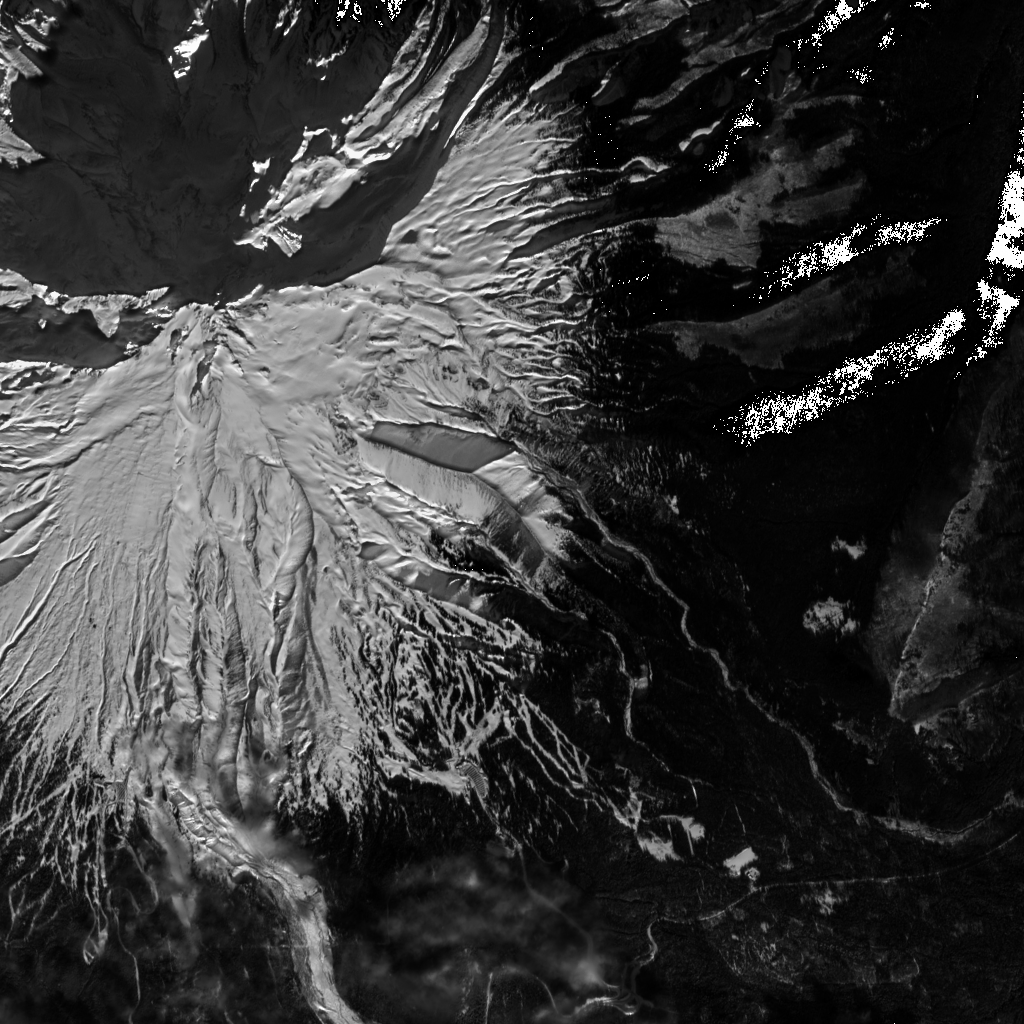

In [47]:
# we make a whole new map because if we screwed
# something up we only have to re-run this cell to fix it
raster_map = folium.Map(
    location=location,
    tiles='CartoDB positron',
)

folium.CircleMarker(
    location=location,
    fill=True,
    fill_opacity=0.6,
).add_to(raster_map)

folium.GeoJson(item).add_to(raster_map)

folium.raster_layers.ImageOverlay(
    tile_array_scaled_offset,
    bounds=[[min_lat, min_long], [max_lat, max_long]],
    name='tile',
).add_to(raster_map)

folium.LayerControl().add_to(raster_map)

raster_map

## Additional exercises to consider later

* Find how many overviews are in this file.
* Find the dimensions and gsd of each overview.
* Repeat reading the tile containing your point of interest, but do so from one of the overviews.
* How can we make reading the file more efficient? Can we get all the IFDs in the file with a single read without having to read in image data?
* Can you write the TIFF for the map visualization yourself instead of using an external lib?
* Repeat these exercises with a multiband TIFF to see how the file structure differs to support the additional bands.

Any other cool ideas? Let me know and/or share with the group.